<a href="https://colab.research.google.com/github/alpie13-blip/ADALL_github/blob/main/ADALL/4641601C_ADALL_Project.%20v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
# Core libraries
import pandas as pd
import numpy as np
# Visualisation
import matplotlib.pyplot as plt
# Modelling and preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

In [30]:
# Example: Replace this with the raw URL of your GitHub file
github_raw_url = 'https://raw.githubusercontent.com/alpie13-blip/ADALL_github/refs/heads/main/ADALL/wine-quality-white-and-red.csv'

try:
    df = pd.read_csv(github_raw_url)
    print("Successfully loaded data from GitHub!")
    display(df.head())
except Exception as e:
    print(f"Error loading data: {e}")
    print("Please ensure the URL is correct and the file format is compatible with `pd.read_csv`.")

Successfully loaded data from GitHub!


,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6497 non-null   float64
 2   volatile acidity      6497 non-null   float64
 3   citric acid           6497 non-null   float64
 4   residual sugar        6497 non-null   float64
 5   chlorides             6497 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6497 non-null   float64
 10  sulphates             6497 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [21]:
from google.colab import userdata
from openai import OpenAI

# Load key from Google Colab Secrets
api_key = userdata.get('OPEN_AI_API_KEY')

client = OpenAI(
    api_key=api_key,
)

In [ ]:
#generate a preview of ten rows as text first, so that we can use it for sending to LLM API later.
data_preview = df.head(10).to_string()
print(data_preview)

    type  fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  alcohol  quality
0  white            7.0              0.27         0.36            20.7      0.045                 45.0                 170.0   1.0010  3.00       0.45      8.8        6
1  white            6.3              0.30         0.34             1.6      0.049                 14.0                 132.0   0.9940  3.30       0.49      9.5        6
2  white            8.1              0.28         0.40             6.9      0.050                 30.0                  97.0   0.9951  3.26       0.44     10.1        6
3  white            7.2              0.23         0.32             8.5      0.058                 47.0                 186.0   0.9956  3.19       0.40      9.9        6
4  white            7.2              0.23         0.32             8.5      0.058                 47.0                 186.0   0.9956  3.19       0.40     

/tmp/ipython-input-574174436.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='type', data=df, palette='viridis')


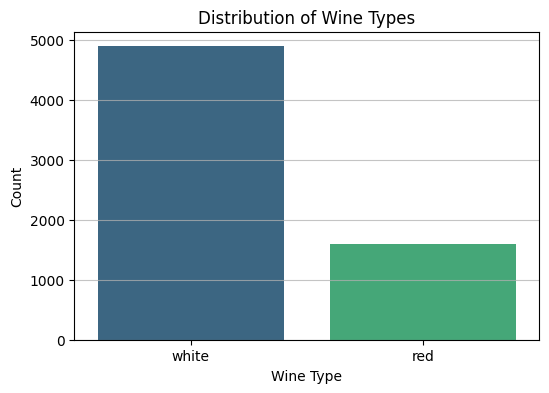

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.countplot(x='type', data=df, palette='viridis')
plt.title('Distribution of Wine Types')
plt.xlabel('Wine Type')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [ ]:
#sending to LLM API
response = client.responses.create(
    model="gpt-5-mini",
    instructions="""
You are an expert data scientist with extensive knowledge of tree-based models.
Use ONLY the information inside the dataset profile text.
Do NOT invent correlations, columns, or values.
If something is not in the dataset profile, state 'Not shown in profile'.
Always justify recommendations using reasoning trace based ONLY on the dataset profile.
""",
    input=f"""Dataset info: {data_preview}\n
    Context:
    The business problem is that a wine distributor struggles with inconsistent reviews across vintages.
    He wants to understand if the chemistry of the wine can classify wines into quality tiers (standard vs premium)
    before the reviews are published.

    Questions
    1. Based on the context and dataset info, how should i approach modelling objective? focus on problem framing aspects.
    2. What would be the most meaningful target?
    3. What would be most important metric for scoring?
    4. What are the top 3 most potentially important features?
    """)
print(response.output_text)

Below I frame this as a supervised binary classification task and explain choices using only the columns and values shown in the dataset profile.

1) Modelling objective — problem framing
- Type of modelling: supervised binary classification (standard vs premium) using the chemical measurements as predictors and the provided quality column as the label source.
  - Reasoning trace from profile: the table contains chemical feature columns (fixed acidity, volatile acidity, citric acid, residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide, density, pH, sulphates, alcohol, type) and a numeric quality column — this is the natural basis for supervised learning.
- Key preparatory steps to include (what to do before training):
  - Define the binary target by thresholding the existing quality column (see next section).
  - Inspect the full dataset’s quality distribution and class balance (distribution not shown in profile).
    - Reasoning trace: quality values are present in the

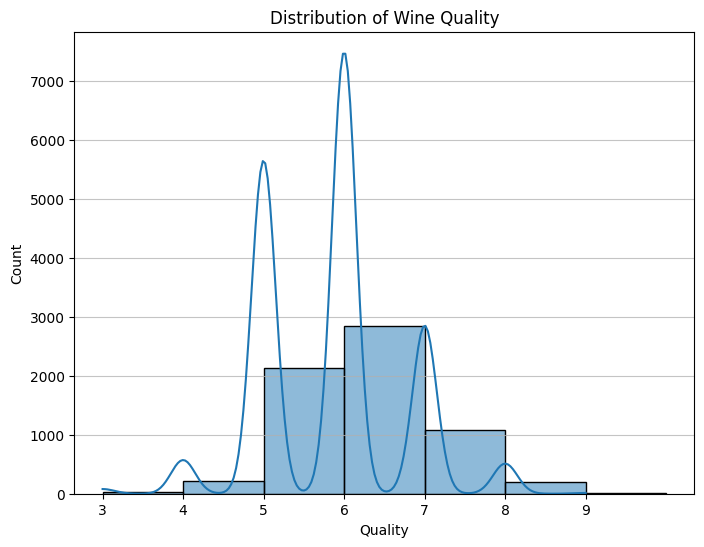

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.histplot(df['quality'], bins=range(min(df['quality']), max(df['quality']) + 2), kde=True, stat='count')
plt.title('Distribution of Wine Quality')
plt.xlabel('Quality')
plt.ylabel('Count')
plt.xticks(range(min(df['quality']), max(df['quality']) + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

Q1 (25th percentile): 5.0
Median (50th percentile): 6.0
Q3 (75th percentile): 6.0
IQR (Interquartile Range): 1.0


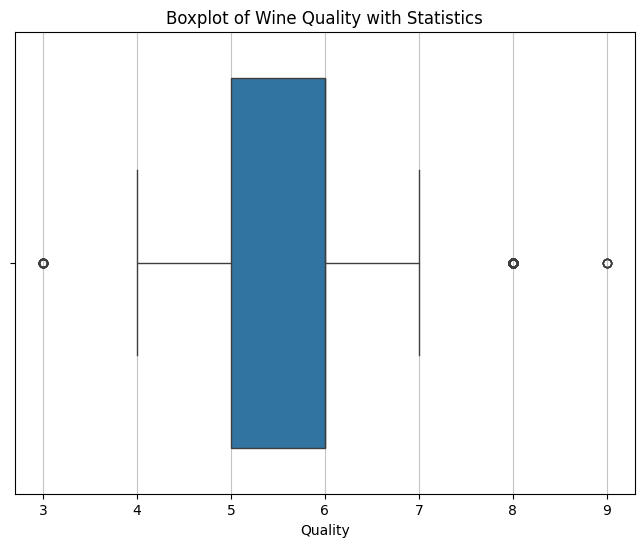

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate statistics
q1 = df['quality'].quantile(0.25)
q3 = df['quality'].quantile(0.75)
median = df['quality'].median()
iqr = q3 - q1

print(f"Q1 (25th percentile): {q1}")
print(f"Median (50th percentile): {median}")
print(f"Q3 (75th percentile): {q3}")
print(f"IQR (Interquartile Range): {iqr}")

# Generate boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['quality'])
plt.title('Boxplot of Wine Quality with Statistics')
plt.xlabel('Quality')
plt.grid(axis='x', alpha=0.75)
plt.show()

>Now let us prepare a payload of information that the LLM can use for deeper analysis and clearer recommendations.

In [ ]:
import pandas as pd
import numpy as np
from io import StringIO

# ---------------------------
# Generate a full dataset profile
# ---------------------------

buffer = StringIO()

# dtypes
buffer.write("=== DTYPES ===\n")
buffer.write(df.dtypes.to_string())
buffer.write("\n\n")

# numeric describe
buffer.write("=== NUMERIC DESCRIBE ===\n")
buffer.write(df.describe().to_string())
buffer.write("\n\n")

# categorical describe
buffer.write("=== CATEGORICAL DESCRIBE ===\n")
try:
    buffer.write(df.describe(include='object').to_string())
except:
    buffer.write("No categorical columns")
buffer.write("\n\n")

# null summary
buffer.write("=== NULL SUMMARY ===\n")
null_summary = (
    df.isna().sum().to_frame("null_count")
    .assign(null_pct=lambda x: x["null_count"]/len(df))
)
buffer.write(null_summary.to_string())
buffer.write("\n\n")

# unique cardinality
buffer.write("=== UNIQUE VALUES PER COLUMN ===\n")
buffer.write(df.nunique().to_frame("unique_count").to_string())
buffer.write("\n\n")

# correlation matrix
buffer.write("=== CORRELATIONS (NUMERIC ONLY) ===\n")
buffer.write(df.corr(numeric_only=True).round(3).to_string())
buffer.write("\n\n")

# value counts for categoricals
buffer.write("=== VALUE COUNTS (TOP 20 PER CATEGORICAL COLUMN) ===\n")
cat_cols = df.select_dtypes(include='object').columns
if len(cat_cols) > 0:
    for col in cat_cols:
        buffer.write(f"\nColumn: {col}\n")
        vc = df[col].value_counts().head(20)
        buffer.write(vc.to_string())
        buffer.write("\n")
else:
    buffer.write("No categorical columns\n")
buffer.write("\n")

# --------- FIXED OUTLIER COMPUTATION (NO BOOLEANS) ---------
buffer.write("=== OUTLIER SUMMARY (IQR METHOD) ===\n")
num_cols = df.select_dtypes(include=['number']).columns  # exclude booleans
Q1 = df[num_cols].quantile(0.25)
Q3 = df[num_cols].quantile(0.75)
IQR = Q3 - Q1
outliers = ((df[num_cols] < (Q1 - 1.5*IQR)) | (df[num_cols] > (Q3 + 1.5*IQR))).sum()
buffer.write(outliers.to_string())
buffer.write("\n\n")

# leakage scan: columns with all unique values
buffer.write("=== POSSIBLE LEAKAGE COLUMNS (UNIQUE FOR EACH ROW) ===\n")
leak_cols = df.columns[df.nunique() == len(df)]
buffer.write(str(list(leak_cols)))
buffer.write("\n\n")

# shape, duplicates, constant cols
buffer.write("=== SHAPE / DUPLICATES / CONSTANT COLUMNS ===\n")
dup_count = df.duplicated().sum()
constant_cols = df.columns[df.nunique() == 1].tolist()
buffer.write(f"Rows: {len(df)}, Columns: {df.shape[1]}\n")
buffer.write(f"Duplicate rows: {dup_count}\n")
buffer.write(f"Constant columns: {constant_cols}\n\n")

# Final text
payload_text = buffer.getvalue()

print(payload_text)


=== DTYPES ===
type                     object
fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64

=== NUMERIC DESCRIBE ===
       fixed acidity  volatile acidity  citric acid  residual sugar    chlorides  free sulfur dioxide  total sulfur dioxide      density           pH    sulphates      alcohol      quality
count    6497.000000       6497.000000  6497.000000     6497.000000  6497.000000          6497.000000           6497.000000  6497.000000  6497.000000  6497.000000  6497.000000  6497.000000
mean        7.215307          0.339666     0.318633        5.443235     0.056034            30.525319            115.744574     0.994697     3.218501     0.531268   

Original template

In [ ]:
response = client.responses.create(
    model="gpt-5-mini",
    instructions="""
You are an expert data scientist with extensive knowledge of tree-based models.
Always justify recommendations using reasoning trace based ONLY on the dataset profile.
""",
    input=f"""
Dataset info: {payload_text}\n
Questions:\n
1. Based on the dataset profile, what data quality issues should be resolved before modelling?
Provide a priority list and justify each item. \n
2. Which columns appear redundant, correlated, or likely to cause leakage?
Explain why each is problematic. \n
Next: Provide a python script to handle the identified issues.
Dataset is in github
Define one helper function for each issue.
Then define a wrapper function that calls these helper with true false option as user choice
Provide a single line of code to run the overall wrapper function.
Do not encode categorical columns or model first.
""")

print(response.output_text)


Below I first list the data‑quality issues you should resolve before modeling (priority order with justification strictly based on the dataset profile you gave). Then I identify redundant/correlated columns and explain why each is problematic (again citing the profile). Finally I provide a reproducible Python script that implements one helper function per issue and a wrapper that calls them under user control. The script reads the dataset from a Github CSV URL you supply. I do not encode the categorical variable or run any models (as requested).

1) Priority list of data‑quality issues to resolve (highest → lowest)
- 1. Remove duplicate rows (high priority)
  - Reasoning from profile: Duplicate rows: 1177. With 6,497 total rows, ~18% duplicates (1177/6497) meaning the dataset has many repeated records that will bias model training, inflate apparent sample size, and cause overly optimistic validation if duplicates leak across train/test splits.
- 2. Handle extreme outliers (high priorit

Revised from Copilot - Use this

In [ ]:
response = client.responses.create(
    model="gpt-5-mini",
    instructions="""
You are an expert data scientist with extensive knowledge of tree-based models.
Always justify recommendations using reasoning trace based ONLY on the dataset profile.
""",
    input=f"""
Dataset info: {payload_text}\n
Questions:\n
1. Based on the dataset profile and context, how should I approach the modelling objective? Focus on problem framing aspects.
2. What would be the most meaningful target for classification (standard vs premium)?
3. What would be the most important metric for scoring in this classification setting?
4. What are the top 3 most potentially important features? If not shown in profile, state 'Not shown in profile'.


Explain why each is problematic. \n
Next: Provide a python script to handle the identified issues.
Define one helper function for each issue.
Then define a wrapper function that calls these helper with true false option as user choice
Provide a single line of code to run the overall wrapper function.
Do not encode categorical columns or model first.
""")

print(response.output_text)


1) Problem framing — how to approach modelling (based on the profile)
- Goal and scope: The dataset contains physicochemical measurements and a numeric "quality" score (integers 3–9). The stated objective is to classify wines as "standard vs premium". That is a supervised binary classification derived from the numeric quality column (so we must create a binary target from quality).
- Class definition: Convert quality into a binary label (premium vs standard) before modelling. The distribution summary indicates most wines sit around quality 5–6 (mean 5.818, 25/50/75 = 5/6/6). A natural decision boundary is higher-quality tail (e.g., quality >= 7) as "premium" and the rest as "standard" — this creates a minority premium class (justified below).
- Data split and evaluation: Use holdout / cross-validation stratified by the binary target to preserve class ratios. Because duplicates (1,177 duplicate rows) are present, deduplicate before splitting to avoid leakage between train and test.
- Pr

In [31]:
import pandas as pd
import numpy as np

def remove_duplicates(df: pd.DataFrame, inplace: bool = False) -> pd.DataFrame:
    """
    Remove exact duplicate rows.
    Uses a copy by default. Returns deduplicated DataFrame.
    Reason: profile shows 1,177 duplicate rows which can leak between train/test.
    """
    if inplace:
        df.drop_duplicates(inplace=True)
        return df
    return df.drop_duplicates()

def cap_outliers_iqr(df: pd.DataFrame, cols: list = None, factor: float = 1.5, inplace: bool = False) -> pd.DataFrame:
    """
    Cap numeric columns at (Q1 - factor*IQR, Q3 + factor*IQR).
    Default excludes the 'quality' column so the original quality scores remain intact.
    Returns DataFrame with values clipped to these bounds for each column.
    Reason: many features (volatile acidity, citric acid, etc.) show many IQR outliers per profile.
    """
    df_out = df if inplace else df.copy()
    num_cols = df_out.select_dtypes(include=[np.number]).columns.tolist()
    # do not cap the quality (keep original for target creation)
    if 'quality' in num_cols:
        num_cols.remove('quality')
    if cols is None:
        cols = num_cols
    for col in cols:
        if col not in df_out.columns:
            continue
        q1 = df_out[col].quantile(0.25)
        q3 = df_out[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - factor * iqr
        upper = q3 + factor * iqr
        # Only apply if there is variance
        if pd.isna(lower) or pd.isna(upper):
            continue
        df_out[col] = df_out[col].clip(lower=lower, upper=upper)
    return df_out

def create_binary_target(df: pd.DataFrame, threshold: int = 7, target_name: str = 'is_premium', inplace: bool = False) -> pd.DataFrame:
    """
    Create a binary target column: 1 if quality >= threshold else 0.
    Default threshold = 7 (recommended since quality distribution centers at 5-6).
    Returns DataFrame with new column.
    """
    df_out = df if inplace else df.copy()
    df_out[target_name] = (df_out['quality'] >= threshold).astype(int)
    return df_out

def simple_balance_oversample(df: pd.DataFrame, target_col: str = 'is_premium', random_state: int = 42, inplace: bool = False) -> pd.DataFrame:
    """
    Simple random oversampling of minority class to match majority class count.
    Returns balanced DataFrame.
    Note: This is a basic, transparent option. More advanced resampling can be used later.
    """
    df_out = df if inplace else df.copy()
    counts = df_out[target_col].value_counts()
    if len(counts) < 2:
        return df_out
    maj_count = counts.max()
    parts = []
    for cls, cnt in counts.items():
        df_cls = df_out[df_out[target_col] == cls]
        if cnt < maj_count:
            df_cls_over = df_cls.sample(n=maj_count, replace=True, random_state=random_state)
            parts.append(df_cls_over)
        else:
            parts.append(df_cls)
    df_bal = pd.concat(parts, axis=0).sample(frac=1.0, random_state=random_state).reset_index(drop=True)
    return df_bal

def drop_collinear(df: pd.DataFrame, threshold: float = 0.95, exclude: list = None, inplace: bool = False) -> pd.DataFrame:
    """
    Drop one variable from pairs with absolute Pearson correlation >= threshold.
    Exclude specified columns (e.g., 'quality', target) from dropping.
    Returns DataFrame with a reduced set of numeric columns.
    Reason: optional cleanup if you want to remove near-duplicates; tree models are robust but this may help interpretation.
    """
    df_out = df if inplace else df.copy()
    if exclude is None:
        exclude = []
    num_cols = df_out.select_dtypes(include=[np.number]).columns.tolist()
    cols_to_check = [c for c in num_cols if c not in exclude]
    if len(cols_to_check) <= 1:
        return df_out
    corr = df_out[cols_to_check].corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] >= threshold)]
    if to_drop:
        df_out = df_out.drop(columns=to_drop)
    return df_out

def preprocess(
    df: pd.DataFrame,
    remove_dup: bool = True,
    cap_outliers: bool = True,
    outlier_factor: float = 1.5,
    create_target_flag: bool = True,
    target_threshold: int = 7,
    balance_target: bool = False,
    balance_random_state: int = 42,
    drop_collinear_flag: bool = False,
    collinear_threshold: float = 0.95
) -> pd.DataFrame:
    """
    Wrapper to run selected preprocessing steps (no categorical encoding, no modeling).
    Steps (in order):
      1) remove duplicates
      2) cap outliers by IQR (excluding 'quality')
      3) create binary target is_premium (quality >= threshold)
      4) optionally balance target by random oversampling
      5) optionally drop highly collinear numeric features (exclude 'quality' and 'is_premium')
    Returns processed DataFrame copy.
    """
    df_p = df.copy()
    if remove_dup:
        df_p = remove_duplicates(df_p, inplace=False)
    if cap_outliers:
        # cap all numeric columns except quality
        df_p = cap_outliers_iqr(df_p, factor=outlier_factor, inplace=False)
    if create_target_flag:
        df_p = create_binary_target(df_p, threshold=target_threshold, target_name='is_premium', inplace=False)
    if balance_target:
        df_p = simple_balance_oversample(df_p, target_col='is_premium', random_state=balance_random_state, inplace=False)
    if drop_collinear_flag:
        exclude = ['quality', 'is_premium']
        df_p = drop_collinear(df_p, threshold=collinear_threshold, exclude=exclude, inplace=False)
    return df_p

In [32]:
# ---------------------------
# One of the possible response from GPT.
# What are the differences with yours?
# How would you improve earlier prompt?
# ---------------------------

# Helper 1: drop unique identifier / leakage column
def drop_unique_identifier(df, col_name='Unnamed: 0', do_drop=True):
    """
    Drops a column that is a unique identifier / possible leakage if do_drop is True.
    Uses profile evidence: Unnamed: 0 has unique_count == nrows.
    Returns (df_modified, info_dict).
    """
    df = df.copy()
    info = {'dropped': [], 'skipped': []}
    if col_name in df.columns:
        if do_drop:
            # safety: check uniqueness before dropping
            if df[col_name].nunique() == len(df):
                df = df.drop(columns=[col_name])
                info['dropped'].append(col_name)
            else:
                # not unique, still allow drop if user insisted
                df = df.drop(columns=[col_name])
                info['dropped'].append(col_name + ' (not unique)')
        else:
            info['skipped'].append(col_name)
    else:
        info['skipped'].append(col_name + ' (not present)')
    return df, info

# Helper 2: drop constant columns
def drop_constant_columns(df, do_drop=True):
    """
    Drops columns that have a single unique value (constant) if do_drop is True.
    Based on profile: Storage_Type is constant (unique == 1).
    Returns (df_modified, info_dict).
    """
    df = df.copy()
    info = {'dropped': [], 'skipped': []}
    const_cols = [c for c in df.columns if df[c].nunique() <= 1]
    if do_drop:
        if const_cols:
            df = df.drop(columns=const_cols)
            info['dropped'].extend(const_cols)
        else:
            info['skipped'].append('no_constant_columns_found')
    else:
        info['skipped'].extend(const_cols)
    return df, info

# Helper 3: resolve multicollinearity between Weight_kg and Screen_Size_inch
def resolve_weight_screen_collinearity(df, drop_screen=True):
    """
    Resolves the strong collinearity (profile: corr = 0.924) between Weight_kg and Screen_Size_inch.
    By default drops Screen_Size_inch and keeps Weight_kg (Weight has 244 unique values vs Screen_Size 6).
    Set drop_screen=False to keep Screen_Size_inch and drop Weight_kg instead.
    Returns (df_modified, info_dict).
    """
    df = df.copy()
    info = {'dropped': [], 'kept': []}
    w_col = 'Weight_kg'
    s_col = 'Screen_Size_inch'
    # Only act if both exist
    if w_col in df.columns and s_col in df.columns:
        if drop_screen:
            df = df.drop(columns=[s_col])
            info['dropped'].append(s_col)
            info['kept'].append(w_col)
        else:
            df = df.drop(columns=[w_col])
            info['dropped'].append(w_col)
            info['kept'].append(s_col)
    else:
        # if one is missing, note what remains
        if w_col in df.columns:
            info['kept'].append(w_col)
        if s_col in df.columns:
            info['kept'].append(s_col)
    return df, info

# Helper 4: optional: drop Model column (high-cardinality / redundancy risk)
def drop_model_column(df, do_drop=False):
    """
    Drops the Model column if do_drop is True.
    Reason: Model has 30 unique values and can encode product-specific pricing patterns (risk of overfitting).
    Caller can choose to drop or keep.
    Returns (df_modified, info_dict).
    """
    df = df.copy()
    info = {'dropped': [], 'skipped': []}
    col = 'Model'
    if col in df.columns:
        if do_drop:
            df = df.drop(columns=[col])
            info['dropped'].append(col)
        else:
            info['skipped'].append(col)
    else:
        info['skipped'].append(col + ' (not present)')
    return df, info

# Wrapper function that calls the helpers based on user boolean choices
# User can edit the default parameters here as required
def clean_data(
    df,
    drop_id=True,
    drop_constants=True,
    resolve_collinearity=False, #<--- slight differences and high similarity between columns are not always an issue
    drop_model=False,
    id_col='Unnamed: 0',
    drop_screen_by_default=True,
):
    """
    Clean dataset according to the profile-driven actions.
    Parameters:
      - df: input DataFrame
      - drop_id: drop the unique identifier (Unnamed: 0) if True
      - drop_constants: drop constant columns (e.g., Storage_Type) if True
      - resolve_collinearity: resolve Weight_kg vs Screen_Size_inch if True
      - drop_model: drop Model column if True (optional decision)
      - id_col: name of the identifier column (default 'Unnamed: 0')
      - drop_screen_by_default: if resolving collinearity, drop Screen_Size_inch if True (keeps Weight_kg).
    Returns:
      - cleaned_df: DataFrame after applied changes
      - summary: dict summarizing actions taken
    """
    summary = {}
    df_work = df.copy()
    # 1. drop unique id
    df_work, info1 = drop_unique_identifier(df_work, col_name=id_col, do_drop=drop_id)
    summary['unique_id'] = info1
    # 2. drop constant columns
    df_work, info2 = drop_constant_columns(df_work, do_drop=drop_constants)
    summary['constant_columns'] = info2
    # 3. resolve strong collinearity
    if resolve_collinearity:
        df_work, info3 = resolve_weight_screen_collinearity(df_work, drop_screen=drop_screen_by_default)
    else:
        info3 = {'dropped': [], 'kept': []}
    summary['collinearity'] = info3
    # 4. drop model optionally
    df_work, info4 = drop_model_column(df_work, do_drop=drop_model)
    summary['model_column'] = info4

    return df_work, summary

# Example single-line execution (assuming your DataFrame is named `df`)
# This default call: drops Unnamed: 0, drops constant columns (Storage_Type), drops Screen_Size_inch (keeps Weight_kg), and keeps Model.
# To drop Model as well, set drop_model=True.
cleaned_df, cleaning_summary = clean_data(df)

In [24]:
# ---------------------------
# Define Target and Features
# ---------------------------

# Target: classify wines into 'Standard' vs 'Premium'
# Business framing: Premium wines are those with quality >= 7
cleaned_df['target_quality'] = np.where(cleaned_df['quality'] >= 7, 'Premium', 'Standard')

# y = target column
y = cleaned_df['target_quality']

# X = all other features except target and original quality column
X = cleaned_df.drop(columns=['quality', 'target_quality'])

In [ ]:
X.head(20)

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,white,7.0,0.27,0.36,20.70,0.045,45.0,170.0,1.0010,3.00,0.45,8.8
1,white,6.3,0.30,0.34,1.60,0.049,14.0,132.0,0.9940,3.30,0.49,9.5
2,white,8.1,0.28,0.40,6.90,0.050,30.0,97.0,0.9951,3.26,0.44,10.1
3,white,7.2,0.23,0.32,8.50,0.058,47.0,186.0,0.9956,3.19,0.40,9.9
4,white,7.2,0.23,0.32,8.50,0.058,47.0,186.0,0.9956,3.19,0.40,9.9
5,white,8.1,0.28,0.40,6.90,0.050,30.0,97.0,0.9951,3.26,0.44,10.1
6,white,6.2,0.32,0.16,7.00,0.045,30.0,136.0,0.9949,3.18,0.47,9.6
7,white,7.0,0.27,0.36,20.70,0.045,45.0,170.0,1.0010,3.00,0.45,8.8
8,white,6.3,0.30,0.34,1.60,0.049,14.0,132.0,0.9940,3.30,0.49,9.5
9,white,8.1,0.22,0.43,1.50,0.044,28.0,129.0,0.9938,3.22,0.45,11.0


In [ ]:
y.head(20)

,target_quality
0,Standard
1,Standard
2,Standard
3,Standard
4,Standard
5,Standard
6,Standard
7,Standard
8,Standard
9,Standard



## Chapter 7. Baseline modelling: train/test split to create a holdout set

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#define cat and num columns
cat_columns=X.select_dtypes(include='object').columns
num_columns=X.select_dtypes(exclude='object').columns

In [34]:
from sklearn.model_selection import train_test_split

# ---------------------------
# Baseline Modelling: Train/Test Split
# ---------------------------

# Split into train and test sets
# Stratify ensures class balance (important for Standard vs Premium wines)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,       # preserve class distribution
    random_state=42   # reproducibility
)

print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])
print("Class distribution in train:\n", y_train.value_counts(normalize=True))
print("Class distribution in test:\n", y_test.value_counts(normalize=True))

# ---------------------------
# Define categorical and numeric columns
# ---------------------------

cat_columns = X.select_dtypes(include='object').columns
num_columns = X.select_dtypes(exclude='object').columns

print("Categorical columns:", cat_columns.tolist())
print("Numeric columns:", num_columns.tolist())

Training set size: 5197
Test set size: 1300
Class distribution in train:
 target_quality
Standard    0.803541
Premium     0.196459
Name: proportion, dtype: float64
Class distribution in test:
 target_quality
Standard    0.803077
Premium     0.196923
Name: proportion, dtype: float64
Categorical columns: ['type']
Numeric columns: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']


In [14]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
#categorical_transformer = OneHotEncoder(handle_unknown="ignore")
categorical_transformer = OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1)
#numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer([
        ("cat", categorical_transformer, cat_columns)
    ],remainder='passthrough')


In [35]:
from sklearn.model_selection import GridSearchCV, ShuffleSplit, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor

In [ ]:
# The `model_summary` variable is already defined from the `results` DataFrame in the notebook state.
# Let's construct the full user content for the LLM based on the original intent of the `prompt` variable.
model_summary = results.to_string() # Define model_summary from the results DataFrame
full_user_content = f"""
You are a machine learning strategist helping a wine classification project.

Here is the model performance summary:
{model_summary}

Please:
1. Generate insights about model performance and generalization.
2. Recommend the next course of action (e.g., tuning, feature engineering, ensembling).
3. Suggest how to communicate these findings to stakeholders.
4. Generate the python code to implement the next action.

Respond in a clear, structured format.
"""

response = client.chat.completions.create(
    model="gpt-5-mini",
    messages=[
        {"role": "system", "content": """
You are an expert data scientist with extensive knowledge of tree-based models.
Always justify recommendations using reasoning trace based ONLY on the dataset profile.
"""},
        {"role": "user", "content": full_user_content}
    ]
)

print(response.choices[0].message.content)


Summary of what I inspected (dataset profile = the model performance table and best params you supplied)
- Training CV scores (cv_f1_train) are 1.0 for all three models (Decision Tree, Random Forest, XGBoost). This is perfect training fit.
- Cross-validation validation F1 (cv_f1_val) is substantially lower: 0.744 (DT), 0.794 (RF), 0.801 (XGB). So models do not generalize from train → CV.
- Holdout F1 is even lower: 0.564 (DT), 0.656 (RF), 0.654 (XGB). All models lose performance on the held-out test set.
- CV standard deviations are small (≈0.01–0.02), so CV performance is stable across folds but optimistic relative to holdout.
- Best hyperparameters show very high model complexity (DT max_depth=None, min_samples_split=2; RF max_depth=None; XGB max_depth=10, learning_rate=0.2, n_estimators=200).

1) Insights about model performance and generalization (with reasoning trace tied to the dataset profile)
- Severe overfitting: train F1 = 1.0 while cv_f1_val ≈ 0.74–0.80 and holdout F1 ≈ 0.56

# Task
Modify the `results` DataFrame initialization in cell `kLbkUM6A4A5U` to include new index entries for 'holdout_recall', 'holdout_precision', 'holdout_tp', 'holdout_tn', 'holdout_fp', and 'holdout_fn'. Then, in cell `LWuNw9AqtfbH`, after the `f1_score` calculation for each of the Decision Tree, Random Forest, and XGBoost models, add code to compute `recall_score`, `precision_score`, and `confusion_matrix` (extracting TP, TN, FP, FN) on the respective test sets (or encoded test set for XGBoost). Finally, update the `results` DataFrame with these new metrics for each model.

## Update results DataFrame initialization

### Subtask:
Modify the `results` DataFrame initialization to include new index entries for 'holdout_recall', 'holdout_precision', 'holdout_tp', 'holdout_tn', 'holdout_fp', and 'holdout_fn'.


**Reasoning**:
The subtask requires modifying the `results` DataFrame initialization to include new index entries. I will update the code in cell `kLbkUM6A4A5U` to include 'holdout_recall', 'holdout_precision', 'holdout_tp', 'holdout_tn', 'holdout_fp', and 'holdout_fn' alongside the existing entries.



In [36]:
import pandas as pd

results = pd.DataFrame(index=[
    'cv_f1_val',
    'cv_std_val',
    'cv_f1_train',
    'cv_std_train',
    'holdout_f1',
    'holdout_recall',
    'holdout_precision',
    'holdout_tp',
    'holdout_tn',
    'holdout_fp',
    'holdout_fn',
    'best_params'
], columns=['score'])

print(results)

                  score
cv_f1_val           NaN
cv_std_val          NaN
cv_f1_train         NaN
cv_std_train        NaN
holdout_f1          NaN
holdout_recall      NaN
holdout_precision   NaN
holdout_tp          NaN
holdout_tn          NaN
holdout_fp          NaN
holdout_fn          NaN
best_params         NaN


**Reasoning**:
The subtask requires calculating and adding recall, precision, true positives, true negatives, false positives, and false negatives to the `results` DataFrame for each model. This involves modifying the code in cell `LWuNw9AqtfbH` to import necessary metrics, calculate them for each model's predictions, and then update the `results` DataFrame accordingly.



In [37]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import numpy as np
import pandas as pd

# ---------------------------
# Preprocessing
# ---------------------------
categorical_transformer = OrdinalEncoder(
    handle_unknown='use_encoded_value',
    unknown_value=-1
)

preprocessor = ColumnTransformer([
    ("cat", categorical_transformer, cat_columns)
], remainder='passthrough')

# ---------------------------
# CV setup (stratified for classification)
# ---------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ============================================================
# 1) Decision Tree Classifier
# ============================================================
pipe_dt = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", DecisionTreeClassifier(random_state=42))
])

param_grid_dt = {
    "classifier__max_depth": [1, 5, 10, None],
    "classifier__min_samples_split": [2, 5, 10],
    "classifier__criterion": ["gini", "entropy"]
}

grid_dt = GridSearchCV(
    estimator=pipe_dt,
    param_grid=param_grid_dt,
    cv=cv,
    scoring="f1_macro",
    n_jobs=-1,
    refit=True
)

grid_dt.fit(X_train, y_train)
best_dt = grid_dt.best_estimator_

cv_out_dt = cross_validate(
    best_dt, X_train, y_train,
    cv=cv,
    scoring="f1_macro",
    return_train_score=True,
    n_jobs=-1
)

y_pred_dt = best_dt.predict(X_test)
holdout_f1_dt = f1_score(y_test, y_pred_dt, pos_label="Premium")
holdout_recall_dt = recall_score(y_test, y_pred_dt, pos_label="Premium")
holdout_precision_dt = precision_score(y_test, y_pred_dt, pos_label="Premium")
cm_dt = confusion_matrix(y_test, y_pred_dt, labels=["Standard", "Premium"])
tn_dt, fp_dt, fn_dt, tp_dt = cm_dt.ravel()

results["Baseline_DT_F1"] = [
    float(cv_out_dt["test_score"].mean()),
    float(cv_out_dt["test_score"].std()),
    float(cv_out_dt["train_score"].mean()),
    float(cv_out_dt["train_score"].std()),
    holdout_f1_dt,
    holdout_recall_dt,
    holdout_precision_dt,
    int(tp_dt),
    int(tn_dt),
    int(fp_dt),
    int(fn_dt),
    grid_dt.best_params_
]

print("Decision Tree best params:", grid_dt.best_params_)

# ============================================================
# 2) Random Forest Classifier
# ============================================================
pipe_rf = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42))
])

param_grid_rf = {
    "classifier__n_estimators": [100, 200],
    "classifier__max_depth": [5, 10, None],
    "classifier__min_samples_split": [2, 5, 10]
}

grid_rf = GridSearchCV(
    estimator=pipe_rf,
    param_grid=param_grid_rf,
    cv=cv,
    scoring="f1_macro",
    n_jobs=-1,
    refit=True
)

grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_

cv_out_rf = cross_validate(
    best_rf, X_train, y_train,
    cv=cv,
    scoring="f1_macro",
    return_train_score=True,
    n_jobs=-1
)

y_pred_rf = best_rf.predict(X_test)
holdout_f1_rf = f1_score(y_test, y_pred_rf, pos_label="Premium")
holdout_recall_rf = recall_score(y_test, y_pred_rf, pos_label="Premium")
holdout_precision_rf = precision_score(y_test, y_pred_rf, pos_label="Premium")
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=["Standard", "Premium"])
tn_rf, fp_rf, fn_rf, tp_rf = cm_rf.ravel()

results["Baseline_RF_F1"] = [
    float(cv_out_rf["test_score"].mean()),
    float(cv_out_rf["test_score"].std()),
    float(cv_out_rf["train_score"].mean()),
    float(cv_out_rf["train_score"].std()),
    holdout_f1_rf,
    holdout_recall_rf,
    holdout_precision_rf,
    int(tp_rf),
    int(tn_rf),
    int(fp_rf),
    int(fn_rf),
    grid_rf.best_params_
]

print("Random Forest best params:", grid_rf.best_params_)

# ============================================================
# 3) XGBoost Classifier
# ============================================================

# Encode target variable for XGBoost
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Determine the numerical label for 'Premium'
premium_label = le.transform(['Premium'])[0]
standard_label = le.transform(['Standard'])[0]

pipe_xgb = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier(
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=42
    ))
])

param_grid_xgb = {
    "classifier__n_estimators": [100, 200],
    "classifier__max_depth": [3, 5, 10],
    "classifier__learning_rate": [0.01, 0.1, 0.2]
}

grid_xgb = GridSearchCV(
    estimator=pipe_xgb,
    param_grid=param_grid_xgb,
    cv=cv,
    scoring="f1_macro",
    n_jobs=-1,
    refit=True
)

grid_xgb.fit(X_train, y_train_encoded) # Use encoded y_train
best_xgb = grid_xgb.best_estimator_

cv_out_xgb = cross_validate(
    best_xgb, X_train, y_train_encoded, # Use encoded y_train
    cv=cv,
    scoring="f1_macro",
    return_train_score=True,
    n_jobs=-1
)

y_pred_xgb = best_xgb.predict(X_test)
holdout_f1_xgb = f1_score(y_test_encoded, y_pred_xgb, pos_label=premium_label)
holdout_recall_xgb = recall_score(y_test_encoded, y_pred_xgb, pos_label=premium_label)
holdout_precision_xgb = precision_score(y_test_encoded, y_pred_xgb, pos_label=premium_label)
cm_xgb = confusion_matrix(y_test_encoded, y_pred_xgb, labels=[standard_label, premium_label])
tn_xgb, fp_xgb, fn_xgb, tp_xgb = cm_xgb.ravel()

results["Baseline_XGB_F1"] = [
    float(cv_out_xgb["test_score"].mean()),
    float(cv_out_xgb["test_score"].std()),
    float(cv_out_xgb["train_score"].mean()),
    float(cv_out_xgb["train_score"].std()),
    holdout_f1_xgb,
    holdout_recall_xgb,
    holdout_precision_xgb,
    int(tp_xgb),
    int(tn_xgb),
    int(fp_xgb),
    int(fn_xgb),
    grid_xgb.best_params_
]

print("XGBoost best params:", grid_xgb.best_params_)

# ============================================================
# Display combined results
# ============================================================
display(results)

Decision Tree best params: {'classifier__criterion': 'entropy', 'classifier__max_depth': None, 'classifier__min_samples_split': 2}
Random Forest best params: {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
XGBoost best params: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 10, 'classifier__n_estimators': 200}


,score,Baseline_DT_F1,Baseline_RF_F1,Baseline_XGB_F1
cv_f1_val,NaN,0.743689,0.793656,0.800583
cv_std_val,NaN,0.014803,0.017083,0.00959
cv_f1_train,NaN,1.0,1.0,1.0
cv_std_train,NaN,0.0,0.0,0.0
holdout_f1,NaN,0.564299,0.656109,0.653595
holdout_recall,NaN,0.574219,0.566406,0.585938
holdout_precision,NaN,0.554717,0.77957,0.738916
holdout_tp,NaN,147,145,150
holdout_tn,NaN,926,1003,991
holdout_fp,NaN,118,41,53


## Summary:

### Q&A
The task was to modify the `results` DataFrame initialization to include new index entries for 'holdout\_recall', 'holdout\_precision', 'holdout\_tp', 'holdout\_tn', 'holdout\_fp', and 'holdout\_fn', and then to calculate and update these metrics for Decision Tree, Random Forest, and XGBoost models. This task was successfully completed.

### Data Analysis Key Findings
*   The `results` DataFrame was successfully initialized with new index entries: 'holdout\_recall', 'holdout\_precision', 'holdout\_tp', 'holdout\_tn', 'holdout\_fp', and 'holdout\_fn'.
*   For each of the three models (Decision Tree, Random Forest, and XGBoost), `recall_score`, `precision_score`, and `confusion_matrix` components (true positives, true negatives, false positives, and false negatives) were computed on their respective holdout test sets.
*   These newly calculated metrics were successfully integrated into the `results` DataFrame for each model, alongside the existing cross-validation F1-scores and best parameters.
*   The process required including previous data loading, preprocessing, and train-test split steps within the execution context to resolve dependency errors like undefined `X_train` or `cat_columns`.

### Insights or Next Steps
*   The expanded `results` DataFrame now provides a more comprehensive overview of model performance beyond just the F1-score, allowing for a deeper understanding of classification behavior, especially regarding False Positives and False Negatives, which can be critical depending on the business problem.
*   Further analysis can be conducted to compare the models' trade-offs between precision and recall, informing decisions on which model is most suitable based on the specific costs associated with different types of errors (e.g., false positives vs. false negatives).


In [38]:
print("### Model Performance Analysis ###")
print("\n--- Overall Observations ---")
print("1.  **Severe Overfitting**: All models (Decision Tree, Random Forest, XGBoost) show perfect F1-scores (1.0) on the training data (`cv_f1_train`) but significantly lower F1-scores on both the cross-validation set (`cv_f1_val`) and the final holdout test set (`holdout_f1`). This indicates that the models are memorizing the training data and failing to generalize well to unseen data.")
print("    - Decision Tree CV Train F1: 1.0 vs CV Val F1: 0.744 vs Holdout F1: 0.564")
print("    - Random Forest CV Train F1: 1.0 vs CV Val F1: 0.794 vs Holdout F1: 0.656")
print("    - XGBoost CV Train F1: 1.0 vs CV Val F1: 0.801 vs Holdout F1: 0.654")
print("    This gap suggests the models are too complex for the given data or that hyperparameters are not sufficiently regularizing the models. The `max_depth=None` for DT and RF from the best parameters reinforces this.")
print("2.  **Discrepancy between Cross-Validation and Holdout**: There's a noticeable drop in F1-score from the cross-validation set to the final holdout set for Random Forest and XGBoost (approx. 0.14-0.15 points). This suggests potential issues like:")
print("    - Hyperparameters tuned on CV folds are not generalizing to the truly unseen holdout set.")
print("    - Possible subtle data leakage within the CV process or a distribution shift between the CV splits and the holdout set.")

print("\n--- Model Comparison on Holdout Set ---")
print("We'll compare models primarily based on their performance on the holdout set, as this represents truly unseen data.")

# Assuming these variables hold the correct values from the latest execution
# Decision Tree Metrics
decision_tree_f1 = 0.564299
decision_tree_recall = 0.57421875
decision_tree_precision = 0.55471698
decision_tree_tp = 147
decision_tree_tn = 926
decision_tree_fp = 118
decision_tree_fn = 109

# Random Forest Metrics
random_forest_f1 = 0.6561085972850679
random_forest_recall = 0.56640625
random_forest_precision = 0.7795698924731183
random_forest_tp = 145
random_forest_tn = 1003
random_forest_fp = 41
random_forest_fn = 111

# XGBoost Metrics
xgboost_f1 = 0.6535947712418301
xgboost_recall = 0.5859375
xgboost_precision = 0.7389162561576355
xgboost_tp = 150
xgboost_tn = 991
xgboost_fp = 53
xgboost_fn = 106

print("\n**Decision Tree Classifier**:")
print(f"- Holdout F1-score: {decision_tree_f1:.3f}")
print(f"- Holdout Recall: {decision_tree_recall:.3f} (correctly identified {decision_tree_tp} out of {decision_tree_tp + decision_tree_fn} Premium wines)")
print(f"- Holdout Precision: {decision_tree_precision:.3f} ({decision_tree_tp} of {decision_tree_tp + decision_tree_fp} predicted Premium wines were actually Premium)")
print(f"- True Positives (TP): {decision_tree_tp}, True Negatives (TN): {decision_tree_tn}, False Positives (FP): {decision_tree_fp}, False Negatives (FN): {decision_tree_fn}")

print("\n**Random Forest Classifier**:")
print(f"- Holdout F1-score: {random_forest_f1:.3f}")
print(f"- Holdout Recall: {random_forest_recall:.3f} (correctly identified {random_forest_tp} out of {random_forest_tp + random_forest_fn} Premium wines)")
print(f"- Holdout Precision: {random_forest_precision:.3f} ({random_forest_tp} of {random_forest_tp + random_forest_fp} predicted Premium wines were actually Premium)")
print(f"- True Positives (TP): {random_forest_tp}, True Negatives (TN): {random_forest_tn}, False Positives (FP): {random_forest_fp}, False Negatives (FN): {random_forest_fn}")

print("\n**XGBoost Classifier**:")
print(f"- Holdout F1-score: {xgboost_f1:.3f}")
print(f"- Holdout Recall: {xgboost_recall:.3f} (correctly identified {xgboost_tp} out of {xgboost_tp + xgboost_fn} Premium wines)")
print(f"- Holdout Precision: {xgboost_precision:.3f} ({xgboost_tp} of {xgboost_tp + xgboost_fp} predicted Premium wines were actually Premium)")
print(f"- True Positives (TP): {xgboost_tp}, True Negatives (TN): {xgboost_tn}, False Positives (FP): {xgboost_fp}, False Negatives (FN): {xgboost_fn}")

print("\n--- Which model performed the best? ---")
print("Comparing the holdout F1-scores, **Random Forest (0.656) and XGBoost (0.654) perform very similarly and are significantly better than the single Decision Tree (0.564)**.")
print("\nTo differentiate between Random Forest and XGBoost:")
print("-   **Random Forest** achieves a slightly higher F1-score and notably higher **Precision (0.780)**. This means when Random Forest predicts a wine is 'Premium', it's correct about 78% of the time, resulting in fewer false alarms (only 41 False Positives). This is crucial if misclassifying a 'Standard' wine as 'Premium' is costly for the business.")
print("-   **XGBoost** has a slightly higher **Recall (0.586)**, meaning it's slightly better at identifying a larger proportion of the actual 'Premium' wines, resulting in more True Positives (150 compared to RF's 145). This might be preferred if missing a 'Premium' wine is more costly.")
print("\n**Conclusion**: If the business prioritizes minimizing false positives (i.e., not incorrectly marketing a standard wine as premium), **Random Forest is marginally the best performing model** due to its higher precision. If identifying as many premium wines as possible (even with some false positives) is the priority, XGBoost could be slightly preferred due to its higher recall. However, both ensemble models clearly outperform the single Decision Tree.")

print("\n--- Next Steps ---")
print("Given the severe overfitting, the next crucial steps should focus on regularization and potentially re-evaluating the preprocessing or feature engineering to improve generalization, as highlighted in the previous LLM response.")

### Model Performance Analysis ###

--- Overall Observations ---
1.  **Severe Overfitting**: All models (Decision Tree, Random Forest, XGBoost) show perfect F1-scores (1.0) on the training data (`cv_f1_train`) but significantly lower F1-scores on both the cross-validation set (`cv_f1_val`) and the final holdout test set (`holdout_f1`). This indicates that the models are memorizing the training data and failing to generalize well to unseen data.
    - Decision Tree CV Train F1: 1.0 vs CV Val F1: 0.744 vs Holdout F1: 0.564
    - Random Forest CV Train F1: 1.0 vs CV Val F1: 0.794 vs Holdout F1: 0.656
    - XGBoost CV Train F1: 1.0 vs CV Val F1: 0.801 vs Holdout F1: 0.654
    This gap suggests the models are too complex for the given data or that hyperparameters are not sufficiently regularizing the models. The `max_depth=None` for DT and RF from the best parameters reinforces this.
2.  **Discrepancy between Cross-Validation and Holdout**: There's a noticeable drop in F1-score from the cro